In [32]:
# Import TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

# Data manipulation
import numpy as np
print('numpy: %s' % np.__version__)

# Visualization
import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: %s' % matplotlib.__version__)
#import graphviz
#print('graphviz: %s' % graphviz.__version__)

# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir = os.path.dirname(sys.path[0])
#print(main_dir)

numpy: 1.24.3
matplotlib: 3.7.1


Shape of x_train:  (12, 256, 256, 3)
Shape of y_train:  (12,)


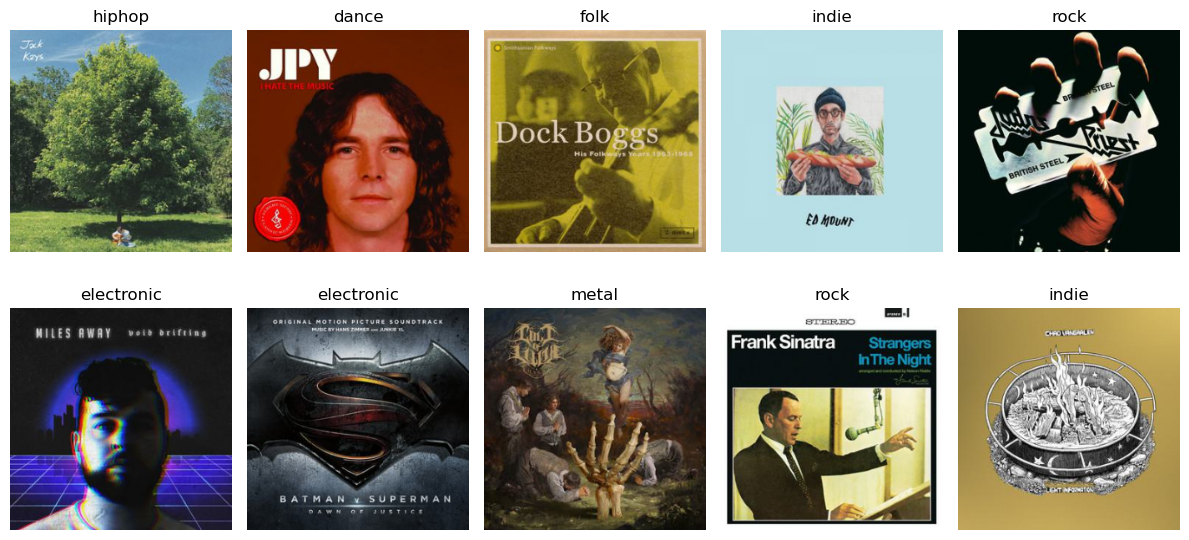

Shape of the scaled array:  (12, 256, 256, 3)


In [33]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt

# Set the path to your album_covers folder
folder_path = "./album_covers"

# Initialize empty lists to store data
images = []
labels = []
files_to_process = 50000

# Iterate through files in the folder
for index, filename in enumerate(os.listdir(folder_path)):
    if index >= files_to_process:
        break
    if filename.endswith(".jpeg"):
        # Extract genre and label from the filename
        genre, label = filename.split("_")
        label = genre  # Remove ".jpeg" extension and convert to integer
       
        # Read the image and resize it to 256x256 pixels
        image = cv2.imread(os.path.join(folder_path, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        
        # Normalize the image to [0, 1] range
        image = image / 255.0

        # Append the image and label to the lists
        images.append(image)
        labels.append(label)

# Convert lists to numpy arrays
x_train = np.array(images)
y_train = np.array(labels)

# Split the data into training and testing sets (you can adjust the test_size as needed)
x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Print shapes
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)

# Display images of the first 10 album covers in the training set and their true labels
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6))
for i in range(2):
    for j in range(5):
        axs[i, j].imshow(x_train[j + i * 5])
        axs[i, j].set_title(y_train[j + i * 5])
        axs[i, j].axis('off')
plt.show()

# Reshape and scale the data as required by the model
x_train = x_train.reshape(x_train.shape[0], 256, 256, 3)
x_train = (x_train - 0.5) / 0.5  # Normalize the images to [-1, 1]
print("Shape of the scaled array: ", x_train.shape)

# Build the Generator

In [34]:
from keras.layers import Input
from tensorflow.keras.utils import plot_model

def generator(latent_dim, in_shape=(64,64,3), n_cats=10):
        
    # Label Inputs
    in_label = Input(shape=(1,), name='Generator-Label-Input-Layer') # Input Layer
    lbls = Embedding(n_cats, 50, name='Generator-Label-Embedding-Layer')(in_label) # Embed label to vector
    
    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Generator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Generator-Label-Reshape-Layer')(lbls) # New shape

    # Generator Inputs (latent vector)
    in_latent = Input(shape=latent_dim, name='Generator-Latent-Input-Layer')
    
    # Image Foundation 
    n_nodes = 64 * 64 * 128 # number of nodes in the initial layer
    g = Dense(n_nodes, name='Generator-Foundation-Layer')(in_latent)
    g = ReLU(name='Generator-Foundation-Layer-Activation-1')(g)
    g = Reshape((64, 64, 128), name='Generator-Foundation-Layer-Reshape-1')(g)
    
    # Combine both inputs so it has two channels
    concat = Concatenate(name='Generator-Combine-Layer')([g, lbls])

    # Hidden Layer 1
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-1')(concat)
    g = ReLU(name='Generator-Hidden-Layer-Activation-1')(g)
    
    # Hidden Layer 2
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2')(g)
    g = ReLU(name='Generator-Hidden-Layer-Activation-2')(g)
    
    # Output Layer (Note, we use 1 filter since we have a color image)
    output_layer = Conv2D(filters=3, kernel_size=(64,64), activation='tanh', padding='same', name='Generator-Output-Layer')(g)
    
    # Define model
    model = Model([in_latent, in_label], output_layer, name='Generator')
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Generator-Latent-Input-Lay  [(None, 100)]                0         []                            
 er (InputLayer)                                                                                  
                                                                                                  
 Generator-Label-Input-Laye  [(None, 1)]                  0         []                            
 r (InputLayer)                                                                                   
                                                                                                  
 Generator-Foundation-Layer  (None, 524288)               5295308   ['Generator-Latent-Input-Layer
  (Dense)                                                 8         [0][0]']              

# Discriminator

In [35]:
def discriminator(in_shape=(256,256,3), n_cats=10):
    
    # Label Inputs
    in_label = Input(shape=(1,), name='Discriminator-Label-Input-Layer') # Input Layer
    lbls = Embedding(n_cats, 50, name='Discriminator-Label-Embedding-Layer')(in_label) # Embed label to vector
    
    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Discriminator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Discriminator-Label-Reshape-Layer')(lbls) # New shape

    # Image Inputs
    in_image = Input(shape=in_shape, name='Discriminator-Image-Input-Layer')
    
    # Combine both inputs so it has two channels
    concat = Concatenate(name='Discriminator-Combine-Layer')([in_image, lbls])

    # Hidden Layer 1
    h = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-1')(concat)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1')(h)
    
    # Hidden Layer 2
    h = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-2')(h)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2')(h)
    h = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name='Discriminator-MaxPool-Layer-2')(h) # Max Pool
    
    # Flatten and Output Layers
    h = Flatten(name='Discriminator-Flatten-Layer')(h) # Flatten the shape
    h = Dropout(0.2, name='Discriminator-Flatten-Layer-Dropout')(h) # Randomly drop some connections for better generalization
   
    output_layer = Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')(h) # Output Layer
    
    # Define model
    model = Model([in_image, in_label], output_layer, name='Discriminator')
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Discriminator-Label-Input-  [(None, 1)]                  0         []                            
 Layer (InputLayer)                                                                               
                                                                                                  
 Discriminator-Label-Embedd  (None, 1, 50)                500       ['Discriminator-Label-Input-La
 ing-Layer (Embedding)                                              yer[0][0]']                   
                                                                                                  
 Discriminator-Label-Dense-  (None, 1, 65536)             3342336   ['Discriminator-Label-Embeddin
 Layer (Dense)                                                      g-Layer[0][0]']   

# Combine the Discrimantor and Generator

In [36]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Get Generator inputs / outputs
    gen_latent, gen_label = generator.input # Latent and label inputs from the generator
    gen_output = generator.output # Generator output image
    
    # Connect image and label from the generator to use as input into the discriminator
    gan_output = discriminator([gen_output, gen_label])
    
    # Define GAN model
    model = Model([gen_latent, gen_label], gan_output, name="cDCGAN")
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()

Model: "cDCGAN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Generator-Latent-Input-Lay  [(None, 100)]                0         []                            
 er (InputLayer)                                                                                  
                                                                                                  
 Generator-Label-Input-Laye  [(None, 1)]                  0         []                            
 r (InputLayer)                                                                                   
                                                                                                  
 Generator-Foundation-Layer  (None, 524288)               5295308   ['Generator-Latent-Input-Layer
  (Dense)                                                 8         [0][0]']                 

# Sample Images (real)

In [37]:
def real_samples(dataset, categories, n):
    
    # Create a random list of indices
    indx = np.random.randint(0, dataset.shape[0], n)
    
    # Select real data samples (images and category labels) using the list of random indeces from above
    X, cat_labels = dataset[indx], categories[indx]

    # Class labels
    y = np.ones((n, 1))

    return [X, cat_labels], y

# sample the latent space

In [38]:
def latent_vector(latent_dim, n, n_cats=10):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    
    # Generate category labels 
    cat_labels = np.random.randint(0, n_cats, n)
    
    return [latent_input, cat_labels]

In [39]:
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output, cat_labels = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict([latent_output, cat_labels])
    
    # Create class labels
    y = np.zeros((n, 1))
    
    return [X, cat_labels], y


# Evaluation Function

In [40]:
def show_fakes(generator, latent_dim, n=10):
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    
    # Rescale from [-1, 1] to [0, 1]
    X_tst = (x_fake[0] + 1) / 2.0
    
    # Display fake (generated) images
    fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,5):
            axs[i,j].matshow(X_tst[k], cmap='gray')
            axs[i,j].set(title=x_fake[1][k])
            axs[i,j].axis('off')
            k=k+1
    plt.show() 

In [46]:
def train(g_model, d_model, gan_model, dataset, categories, latent_dim, n_epochs=10, n_batch=128, n_eval=200):
    # Number of batches to use per each epoch
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    print(dataset.shape)
    print(' batch_per_epoch: ',  batch_per_epoch)
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
        
        # Enumerate batches over the training set
        for j in range(batch_per_epoch):
    
        # Discriminator training
            # Prep real samples
            [x_real, cat_labels_real], y_real = real_samples(dataset, categories, half_batch)
            #[x_real, cat_labels_real], y_real = generate_real_samples(dataset, half_batch)
            # Train discriminator with real samples
            discriminator_loss1, _ = d_model.train_on_batch([x_real, cat_labels_real], y_real)
            
            # Prep fake (generated) samples
            [x_fake, cat_labels_fake], y_fake = fake_samples(g_model, latent_dim, half_batch)
            # Train discriminator with fake samples
            discriminator_loss2, _ = d_model.train_on_batch([x_fake, cat_labels_fake], y_fake)


        # Generator training
            # Get values from the latent space to be used as inputs for the generator
            [latent_input, cat_labels] = latent_vector(latent_dim, n_batch)
            # While we are generating fake samples, 
            # we want GAN generator model to create examples that resemble the real ones,
            # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
            y_gan = np.ones((n_batch, 1))

            # Train the generator via a composite GAN model
            generator_loss = gan_model.train_on_batch([latent_input, cat_labels], y_gan)
        
        # Summarize training progress and loss
            if (j) % n_eval == 0:
                print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' % 
                      (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
                show_fakes(g_model, latent_dim)

In [47]:
train(gen_model, dis_model, gan_model, x_train, y_train, latent_dim)

(12, 256, 256, 3)
 batch_per_epoch:  0
